# Effects of Covid-19 on Unemployment and the Economy
***
### - Correlation between Covid-19 and the S&P.
### - Correlation between Covid-19 and unemployment.
### - U.S. States that were affected the most.
### - Industries that were affected the most.
***
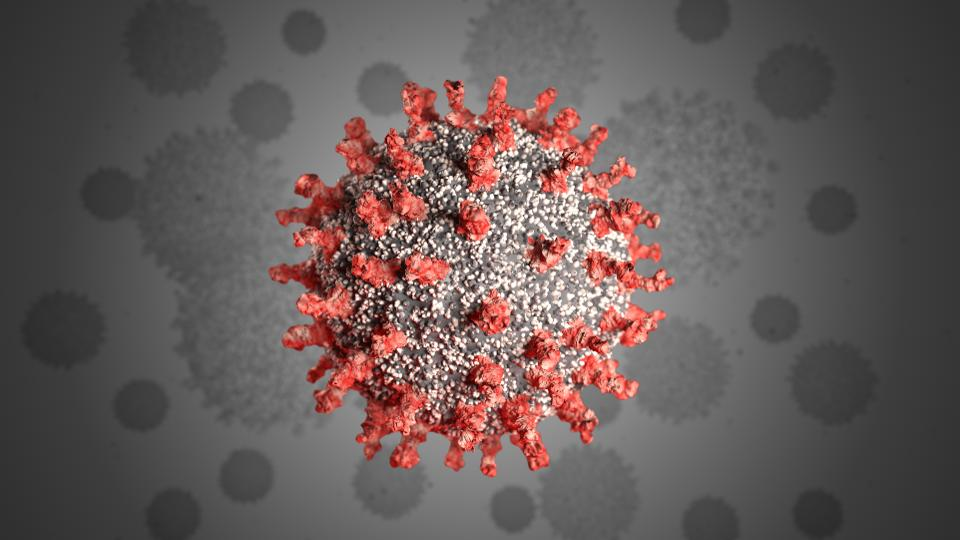

In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import requests
import logging
import json
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import time
from bs4 import BeautifulSoup
from config import vantage_key, census_key, bls_key
import asyncio
import aiohttp
import nest_asyncio
import numpy as np
import folium
import folium.plugins as plugins
from folium.plugins import HeatMap
import random
from scipy import stats

In [2]:
# logging.basicConfig(format='%(asctime)s : %(lineno)d : %(levelname)s : %(message)s', level=logging.DEBUG)

## <font color=blue> This section of code is where we brought in our initial data. To make the data more friendly to time series data, we applied a Lambda function to convert the date column into a proper datetime format.

In [3]:
#Create covid dataframe
covid_response = requests.get("https://covidtracking.com/api/states/daily").json()
covid_dataframe = pd.DataFrame(covid_response)
covid_dataframe['date'] = covid_dataframe['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d')) 
covid_dataframe.head(3)

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-05-15,AK,388.0,32030.0,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,32418,32418,32418,02,0.0,0.0,655.0,1.0,656.0
1,2020-05-15,AL,11216.0,134847.0,NaN,NaN,1377.0,NaN,497.0,NaN,...,1377.0,146063,146063,146063,01,9.0,27.0,3830.0,248.0,4078.0
2,2020-05-15,AR,4463.0,77066.0,NaN,65.0,520.0,NaN,NaN,9.0,...,520.0,81529,81529,81529,05,1.0,11.0,5484.0,227.0,5711.0


## <font color=blue> In this section, we needed to pull in a list of the S&P 500 data as well as industry categories. To do that, we pulled it in from Wikipedia using BeautifulSoup 4. The data was pulled in using a get request, isolating the table data, and then pulling the ‘th’ and ‘td’ content into entrylist.

In [4]:
#Scrapes Wikipedia Table for S&P 500 data
wikipedia_response = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies").text
soup = BeautifulSoup(wikipedia_response,'lxml')
wiki_table = soup.find('table',{'class':'wikitable sortable'})

#This creates a list with the names of the headers
headerslist = []
headers = wiki_table.findAll('th')
for head in headers:
    headerslist.append(head.text)

#This adds the content to a list    
content = wiki_table.findAll('td')
dataframelist = []
entrylist = []
while (content):
    if len(entrylist) < 9:
        contentvalue = content.pop(0).text
        entrylist.append(contentvalue)
    else:
        dataframelist.append(entrylist)
        entrylist = []


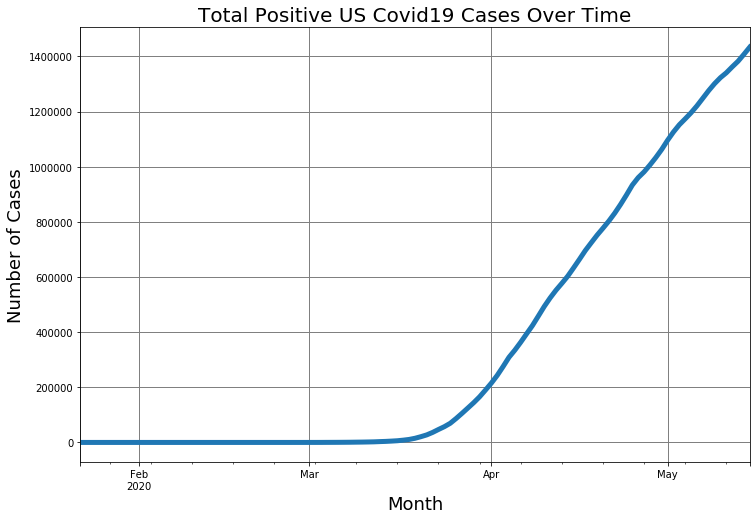

In [5]:
groupedDF = covid_dataframe.groupby(['date'])
positiveseries = groupedDF['positive'].sum()
positiveseries.plot(figsize=(12,8), linewidth=5, legend=False)
plt.grid(color="gray", linestyle='-', linewidth=1)
plt.title("Total Positive US Covid19 Cases Over Time", fontsize=20)
plt.ylabel("Number of Cases", fontsize=18)
plt.xlabel("Month", fontsize=18)
plt.show()

In [6]:
#This creates the S&P dataframe and formats the datetime row
sp500DF = pd.DataFrame(dataframelist, columns=headerslist)
sp500DF['Symbol\n'] = sp500DF['Symbol\n'].str[0:-1]
sp500DF['Founded\n'] = sp500DF['Founded\n'].str[0:-1]
sp500DF['Date first added'] = pd.to_datetime(sp500DF['Date first added'], infer_datetime_format = True, errors='coerce')
sp500DF = sp500DF.rename(columns={'Symbol\n':'Symbol','Founded\n':'Founded'})
# sp500DF

In [7]:
#This joins the industries csv to the sp500 DF
industriesDF = pd.read_csv("Industries.csv")
industriesDF = pd.merge(sp500DF, industriesDF, how='left', left_on="GICS Sub Industry", right_on="GICS Codes/ Sub-industries")
industriesDF = industriesDF[['Symbol', 'Security', 'GICS Sector', 'GICS Sub Industry', 'Headquarters Location', 'Date first added', 'GICS Codes/ Sub-industries', 'NAICS']]
industriesDF.head(3)

,Symbol,Security,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,GICS Codes/ Sub-industries,NAICS
0,MMM,3M Company,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,Industrial Conglomerates,Manufacturing
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,Health Care Equipment,Health care and social assistance
2,ABBV,AbbVie Inc.,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,Pharmaceuticals,Health care and social assistance


# <font color=blue> In this section, we pull in stock data for the past 100 days of each stock listed in the S&P 500. Given that it took a significant amount of time to do this, we leveraged asyncio, which is a python library which supports asynchronous processing. This brought the API time down from 10-20 minutes to a handful of seconds.

In [8]:
#This pulls S&P data from the Alpha Vantage API
#Note that the S&P changes throughout the year
#Also, we're getting the past 100 days on a rolling basis

ticker_list = list(sp500DF['Symbol'].values)

completeurls = [] # completed urls go here

# stockDF = pd.DataFrame(columns=list(stockDF.columns.values))
stockdata = []

# This generates all URLs and places them in a list so that async can create futures out of them
for stocks in ticker_list:
    completeurls.append(f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stocks}&outputsize=compact&apikey={vantage_key}")

nest_asyncio.apply()
async def get_stocks(url):
    connector = aiohttp.TCPConnector(limit=10)
    async with aiohttp.ClientSession(connector=connector, raise_for_status=True) as session:
        async with session.get(url) as response:
            response_content = await response.json()
            response_content['Time Series (Daily)']['symbol'] = url.split("&")[1].split('=')[1] #This extracts the symbol from the URL
            return stockdata.append(response_content['Time Series (Daily)'])

#set up the event loop
asyncio.set_event_loop(asyncio.new_event_loop())
loop = asyncio.get_event_loop()

#add tasks to run
tasks = []
for urls in completeurls:
    future = asyncio.ensure_future(get_stocks(urls))
    tasks.append(future)


#Run
loop.run_until_complete(asyncio.wait(tasks))
# loop.close()


({<Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> exception=KeyError('Time Series (Daily)')>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> result=None>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> result=None>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> result=None>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> result=None>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> result=None>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> result=None>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> result=None>,
  <Task finished coro=<get_stocks() done, defined at <ipython-input-8-dc300588f901>:17> result=None>,
  <Task finished coro=<get_stocks() done, defined at

## <font color=blue>  To make the stock data useful, we had to take data which was a series of nested dictionaries and turn it into something usable. We found that an easy way to do this was to normalize the data using a module within pandas called json_normalize, which basically takes nested dictionaries and transforms them to fit nicely in a dataframe.

In [9]:
#This creates the final stockdata dataframe
stockdata = json_normalize(stockdata)
stockDF = pd.DataFrame(stockdata)
stockDF = stockDF.set_index(['symbol'])
stockDF = stockDF.filter(regex='close')
stockDF.head(3)

,2020-05-15.4. close,2020-05-14.4. close,2020-05-13.4. close,2020-05-12.4. close,2020-05-11.4. close,2020-05-08.4. close,2020-05-07.4. close,2020-05-06.4. close,2020-05-05.4. close,2020-05-04.4. close,...,2020-01-07.4. close,2020-01-06.4. close,2020-01-03.4. close,2020-01-02.4. close,2019-12-31.4. close,2019-12-30.4. close,2019-12-27.4. close,2019-12-26.4. close,2019-12-24.4. close,2019-12-23.4. close
symbol,,,,,,,,,,,,,,,,,,,,,
ABT,89.8900,91.7800,92.1600,93.8000,96.0700,93.7000,93.9900,91.0800,93.0300,89.8300,...,85.8600,86.3400,85.8900,86.9500,86.8600,86.8000,87.4000,87.2800,87.2800,87.3500
ACN,183.8800,179.9900,181.0000,185.7200,187.7500,188.5600,187.1100,180.3800,181.6200,179.5300,...,203.9300,208.4300,209.8000,210.1500,210.5700,210.6400,212.2200,212.0500,211.6100,210.8300
ABBV,90.7100,89.9400,88.8700,90.4600,87.9000,83.9600,84.2200,85.4200,85.3700,81.8600,...,88.8900,89.4000,88.7000,89.5500,88.5400,88.5200,89.2000,89.8300,89.8500,90.2500


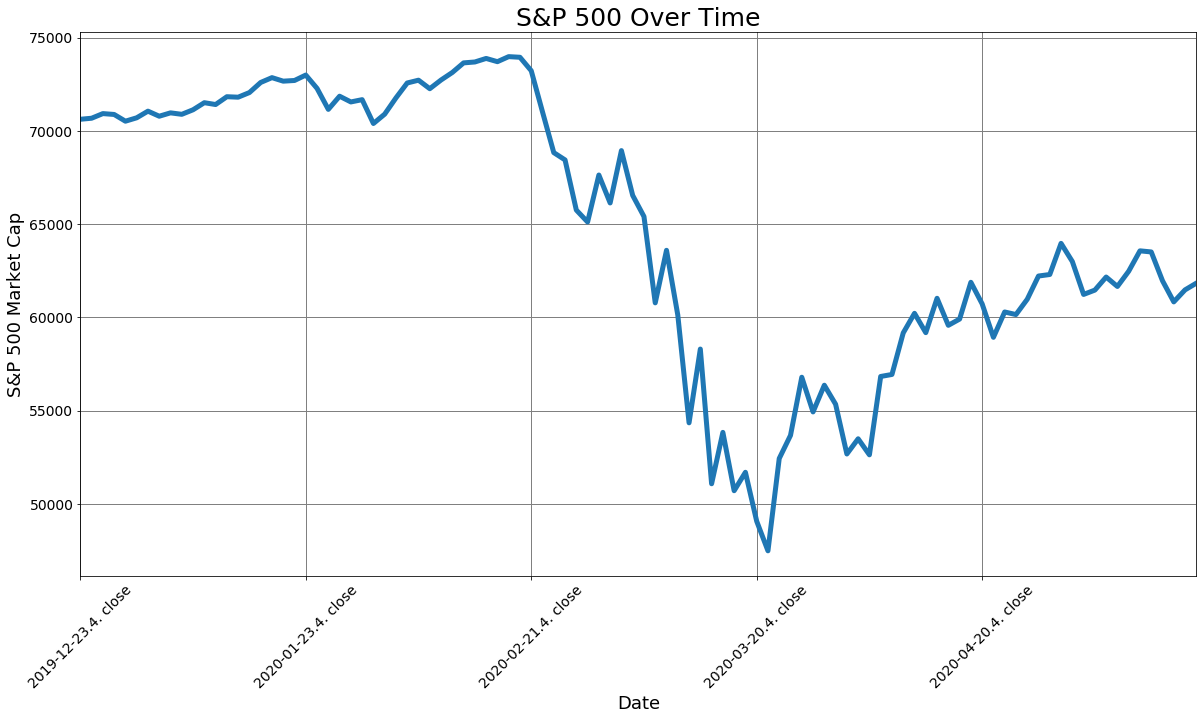

In [10]:
#This creates the final stockdata dataframe
stockDF = stockDF.apply(pd.to_numeric)
stock_visual = stockDF.sum()
stock_visual = stock_visual.sort_index(ascending=True)
stock_visual.plot(figsize=(20,10), linewidth=5, legend=False, fontsize=14)
plt.grid(color="gray", linestyle='-', linewidth=1)
plt.title("S&P 500 Over Time", fontsize=25)
plt.ylabel("S&P 500 Market Cap", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.xticks(rotation=45)
plt.show()

# <font color=red>Correlation Coefficient </font>
***

In [11]:
corcoefficient = stats.pearsonr(list(positiveseries.iloc[15:].values),list(stock_visual.values))
corcoefficient #and P value

(-0.5619241857897663, 1.1798740691397817e-09)

## <font color=blue> For this section, we aggregated and joined 2018 and 2019 population data by state and working population data. Our hopes was that we could use this to drill into the primary industries by state and see how Covid affected those states based on their predominant industries. However, we ran out of runway. This was generally clean data and only required a small amount of cleaning and manipulation. 


In [12]:
#2019 Population data - US Census Bureau
census_response = requests.get(f"https://api.census.gov/data/2019/pep/population?get=COUNTY,DATE_CODE,DATE_DESC,DENSITY,POP,NAME,STATE&for=state:*&key={census_key}").json()
census_headers = census_response.pop(0)
populationDF = pd.DataFrame(census_response, columns = census_headers)
populationDF = populationDF[populationDF['DATE_CODE']=='12']
populationDF = populationDF[['DENSITY','POP','NAME','STATE']]
# populationDF

#This is 2018 population data
census_response2 = requests.get(f"https://api.census.gov/data/2018/pep/population?get=COUNTY,DATE_CODE,DATE_DESC,DENSITY,POP,STATE&for=state:*&key={census_key}").json()
census_headers2 = census_response2.pop(0)
populationDF2 = pd.DataFrame(census_response2, columns = census_headers2)
populationDF2 = populationDF2[populationDF2['DATE_CODE']=='11']
populationDF2 = populationDF2[['DENSITY','POP','STATE']]
# populationDF2

# total jobs 2018 - from bureau of economic analysis (https://apps.bea.gov/iTable/iTable.cfm?reqid=70&step=1&isuri=1)
empByIndDF = pd.read_csv("totalEmpIndustry2018.csv")
workers_by_indDF = pd.read_csv("totaljobs2018.csv")

#Create master Dataframe for 2018 data
populationDF = pd.merge(populationDF, populationDF2, how='left', on="STATE", suffixes=['_2019','_2018'])
master_industryDF = pd.merge(empByIndDF, populationDF, right_on='NAME', left_on='GeoName', how='left')
master_industryDF = pd.merge(master_industryDF, workers_by_indDF, left_on='NAME', right_on='GeoName', how='left')
master_industryDF = master_industryDF[['NAME','STATE','LineCode','Description','2018_x','2018_y','POP_2018','POP_2019']]
master_industryDF = master_industryDF.rename(columns={'2018_x':'2018 Workers In Industry',
                                                      '2018_y':'2018 Working Pop',
                                                      'POP_2019':'2019 Overall Population',
                                                      'POP_2018':'2018 Overall Population',
                                                     })

#Imports state list and attaches the abbreviation
stateDF = pd.read_csv("stateabbrs.csv")
master_industryDF = pd.merge(master_industryDF, stateDF, how='left', left_on="NAME", right_on="State")
master_industryDF = master_industryDF[['NAME',
                                       'Code',
                                       'STATE',
                                       'LineCode',
                                       'Description',
                                       '2018 Workers In Industry',
                                       '2018 Working Pop',
                                       '2018 Overall Population',
                                       '2019 Overall Population'
                                       ]]
master_industryDF['2018 Overall Population'] = pd.to_numeric(master_industryDF['2018 Overall Population'])
master_industryDF['2019 Overall Population'] = pd.to_numeric(master_industryDF['2019 Overall Population'])
master_industryDF['2018 Workers In Industry'] = pd.to_numeric(master_industryDF['2018 Workers In Industry'], errors='coerce')
master_industryDF = master_industryDF.dropna(subset=['2018 Workers In Industry']) #This dropped Delaware's logging industry entry. Not sure of the downstream effects
master_industryDF['2018 Percentage of Working Pop'] = (master_industryDF['2018 Workers In Industry'].astype('int64') / master_industryDF['2018 Working Pop']) * 100
# master_industryDF['2019 Working Pop'] = round(master_industryDF['2019 Overall Population'] * (master_industryDF['2018 Percentage of Working Pop'] / 100),0) 
master_industryDF

,NAME,Code,STATE,LineCode,Description,2018 Workers In Industry,2018 Working Pop,2018 Overall Population,2019 Overall Population,2018 Percentage of Working Pop
0,Alabama,AL,01,70,Farm employment,42220.0,2691517,4887871,4903185,1.568632
1,Alabama,AL,01,100,"Forestry, fishing, and related activities",15895.0,2691517,4887871,4903185,0.590559
2,Alabama,AL,01,200,"Mining, quarrying, and oil and gas extra...",10560.0,2691517,4887871,4903185,0.392344
3,Alabama,AL,01,300,Utilities,14176.0,2691517,4887871,4903185,0.526692
4,Alabama,AL,01,400,Construction,148326.0,2691517,4887871,4903185,5.510870
...,...,...,...,...,...,...,...,...,...,...
1066,Wyoming,WY,56,1600,Health care and social assistance,30617.0,405010,577737,578759,7.559566
1067,Wyoming,WY,56,1700,"Arts, entertainment, and recreation",8255.0,405010,577737,578759,2.038221
1068,Wyoming,WY,56,1800,Accommodation and food services,35917.0,405010,577737,578759,8.868176
1069,Wyoming,WY,56,1900,Other services (except government and go...,17920.0,405010,577737,578759,4.424582


## <font color=blue> The most difficult part of this data was finding what codes we needed to find unemployment rates by state. Once this was accomplished, it was a matter of setting up a loop to pull in each state. We almost always have problems with the last 3 endpoints, which are Puerto Rico, Wyoming and Wisconsin. More generally, this data set really needed to have data for April to be useful, since we know that April was the month where the unemployment rate began to spike.


In [13]:
# US Bureau of Labor Statistics - Returns unadjusted unemployment rates
areaCodesDF = pd.read_csv("bureauoflaborstats.csv")
fips_dict = pd.read_csv("fipscodes.csv")
fips_dict = fips_dict[["State Abbreviation","FIPS Code"]]
fips_dict = fips_dict.to_dict()

#If we want to get more granular, we can switch the area_type_code from A to N
areaCodesList = areaCodesDF[areaCodesDF["area_type_code"]=="A"]
areaCodesList = list(areaCodesList["area_code"].values)

master_unemp_DF = pd.DataFrame({"year":[],"periodName":[],"value":[],"state":[]})

for x in areaCodesList:
    try:
        seriesid = f"LAU{x}03"
        fips_code = x[2:4]
        headers = {'Content-type': 'application/json'} 
        logging.debug(f"RETRIEVING: {x}, {fips_code}")
        data = json.dumps({"seriesid": [seriesid],"startyear":"2010", "endyear":"2020","registrationkey":bls_key})
        response = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers).json()
        state_unemp_DF = pd.DataFrame(response['Results']['series'][0]['data'])
        state_unemp_DF['state'] = fips_dict['State Abbreviation'][int(fips_code)]
        state_unemp_DF = state_unemp_DF[["year","periodName","value","state"]]
        state_unemp_DF['value'] = state_unemp_DF['value'].astype('float')
        master_unemp_DF = master_unemp_DF.append(state_unemp_DF)
    except:
        logging.error(f"Error retrieving data: {x}")


ERROR:root:Error retrieving data: ST5500000000000
ERROR:root:Error retrieving data: ST5600000000000
ERROR:root:Error retrieving data: ST7200000000000


In [14]:
master_unemp_DF

,year,periodName,value,state
0,2020,March,3.3,AL
1,2020,February,2.9,AL
2,2020,January,3.2,AL
3,2019,December,2.5,AL
4,2019,November,2.4,AL
...,...,...,...,...
118,2010,May,8.3,WY
119,2010,April,8.4,WY
120,2010,March,9.3,WY
121,2010,February,10.0,WY


In [15]:
# Create Unemployment rate DF and format month name to numeric
#master_unemp_DFx = master_unemp_DF
#master_unemp_DFx['periodName']  = master_unemp_DFx['periodName'].apply(lambda x: time.strptime(str(x), '%m'))
#master_unemp_DFx = master_unemp_DFx.rename(columns={'periodName':'month'})
#master_unemp_DFx = pd.pivot_table(master_unemp_DFx, index=['state','month'], columns=['year'], values=['value'])
#master_unemp_DFx


## <font color=blue> In this section we cleaned up the unemployment dataframe to plot the graphs.

In [16]:
msx = master_unemp_DF[master_unemp_DF["year"] == "2020"]
msx_cleaned = msx[msx["value"] != "nan"]
msx_cleaned['periodName']  = msx_cleaned['periodName'].apply(lambda x: time.strptime(x, '%B').tm_mon)
msx_cleaned = msx_cleaned.rename(columns={'periodName':'month'})
msx_cleaned.sort_values(by=["state","month"])


/Users/heatherjanemoore/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,year,month,value,state
2,2020,1,3.2,AL
1,2020,2,2.9,AL
0,2020,3,3.3,AL
2,2020,1,6.6,AR
1,2020,2,5.9,AR
...,...,...,...,...
1,2020,2,4.2,WV
0,2020,3,5.3,WV
2,2020,1,5.5,WY
1,2020,2,5.5,WY


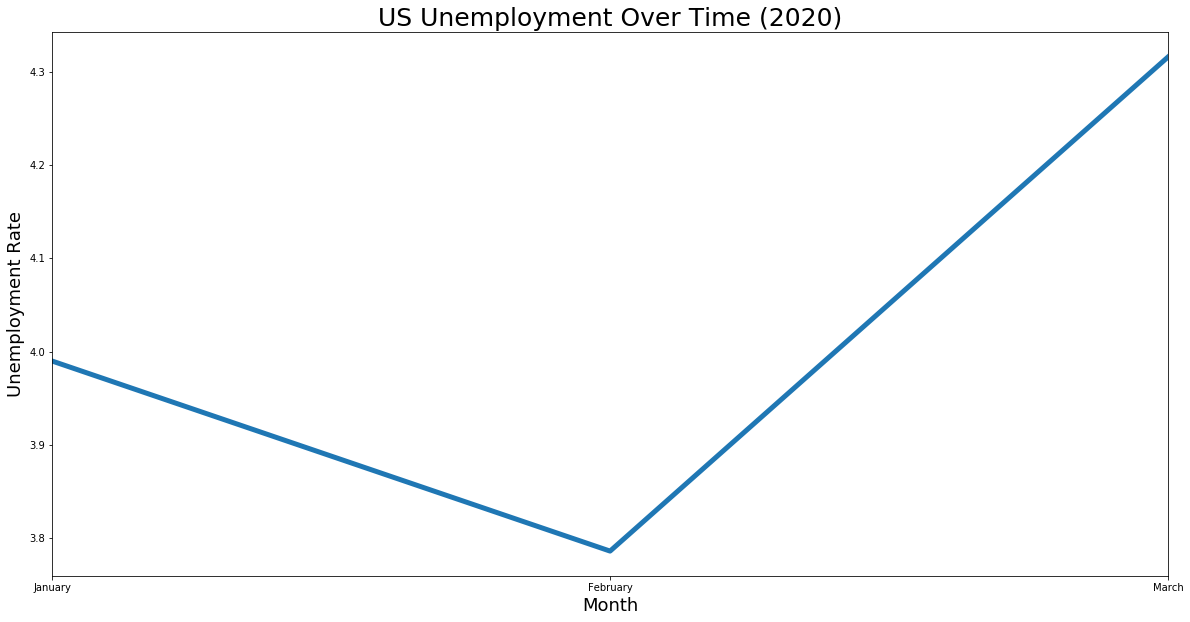

In [17]:
#msx_cleaned.plot()
msxgroupedDF = msx_cleaned.groupby(['month'])
msxAVG = msxgroupedDF['value'].mean()
msxAVG.plot(figsize=(20,10), linewidth=5, legend=False)

locs, labels = plt.xticks() 
plt.xticks([1,2,3], ['January', 'February', 'March']) 

plt.title("US Unemployment Over Time (2020)", fontsize=25)
plt.ylabel("Unemployment Rate", fontsize=18)
plt.xlabel("Month", fontsize=18)
plt.show()
#fig.savefig('Unemployment_line.png')

In [18]:
# msx_cleaned.groupby('state').plot(x='month', y='value', )

In [19]:
msxSelectStates = msx_cleaned[msx_cleaned["state"].isin(["NY", "VA", "MD", "FL", "MI", "NV", "TX", "WA", "CA", "HI"])]
# msxSelectStates.groupby('state').plot(x='month', y='value', legend=True, title = "state")

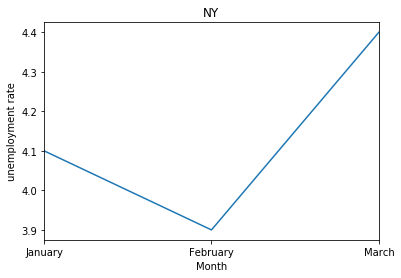

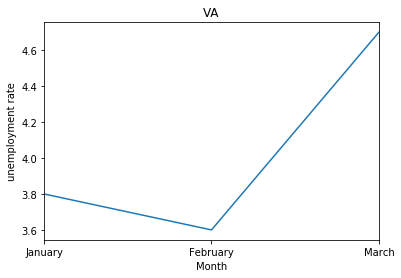

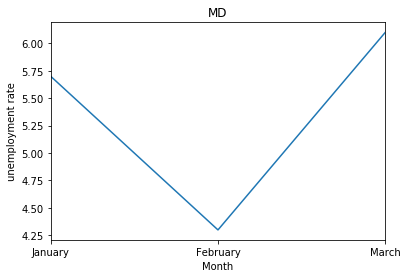

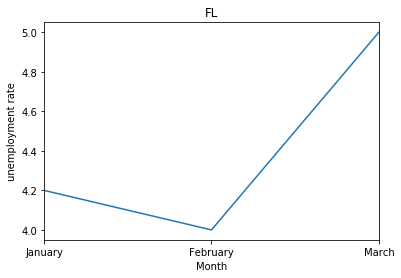

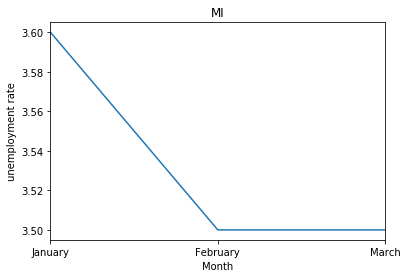

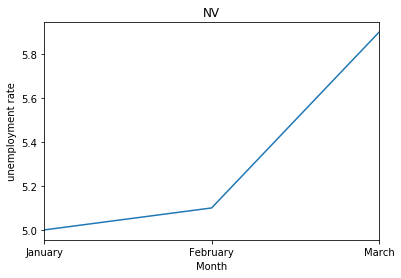

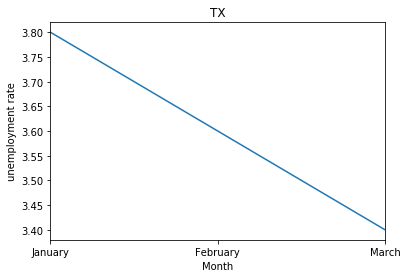

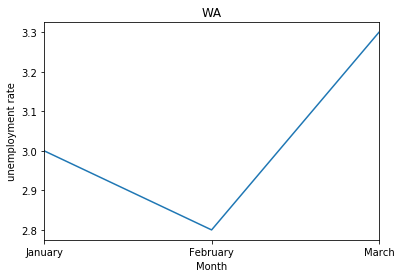

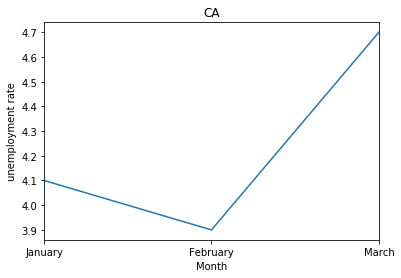

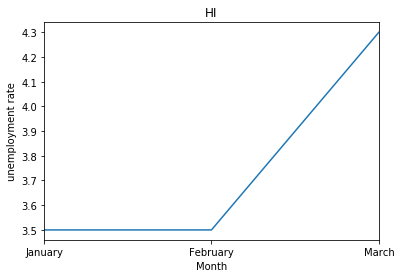

In [20]:
states = ["NY", "VA", "MD", "FL", "MI", "NV", "TX", "WA", "CA", "HI"]
for state in states:
    msxSelectStates1 = msx_cleaned[msx_cleaned["state"] == state]
    msxSelectStates1.groupby('state').plot(x='month', y='value', legend=False, title = state)
    locs, labels = plt.xticks() 
    plt.xticks([1,2,3], ['January', 'February', 'March']) 
    plt.ylabel("unemployment rate")
    plt.xlabel("Month")
    plt.show()
    

Text(0.5, 1.0, 'US Unemployment Rate March')

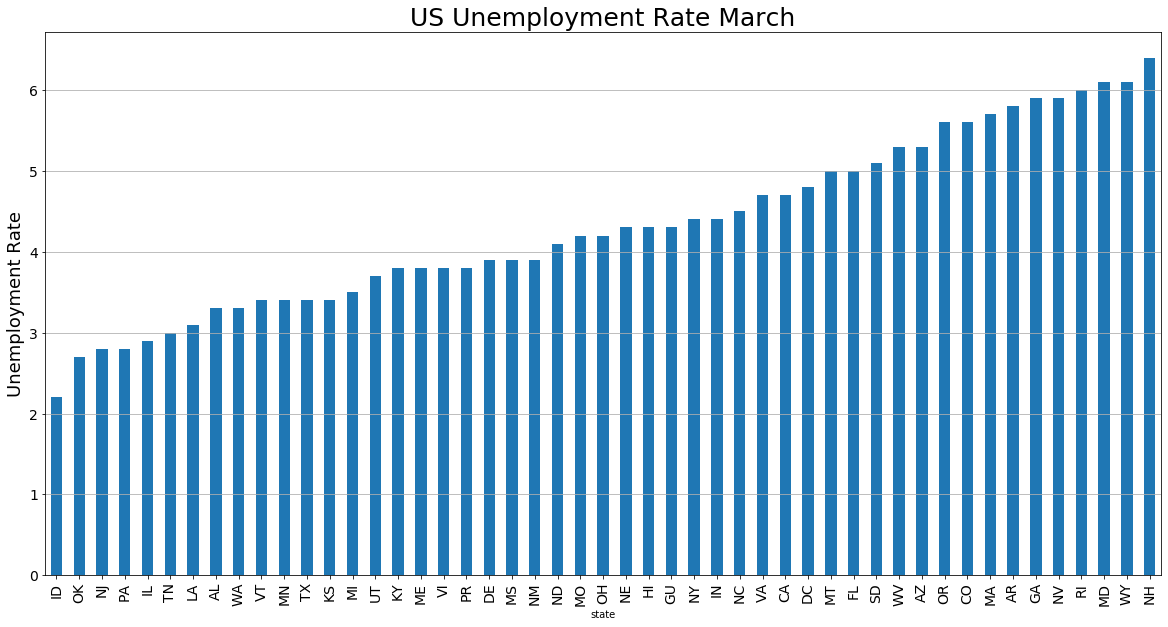

In [21]:
msx_cleaned[msx_cleaned['month']==3].sort_values("value").plot.bar(x='state', y='value', fontsize=14, legend=False, figsize=(20,10)).grid(axis='y')
plt.ylabel("Unemployment Rate", fontsize=18)
plt.title("US Unemployment Rate March", fontsize=25)
#plt.set_axisbelow(True)
#fig.savefig('Unemployment_graph.png')

Text(0.5, 1.0, 'Unemployment Rate Across Sample States for March')

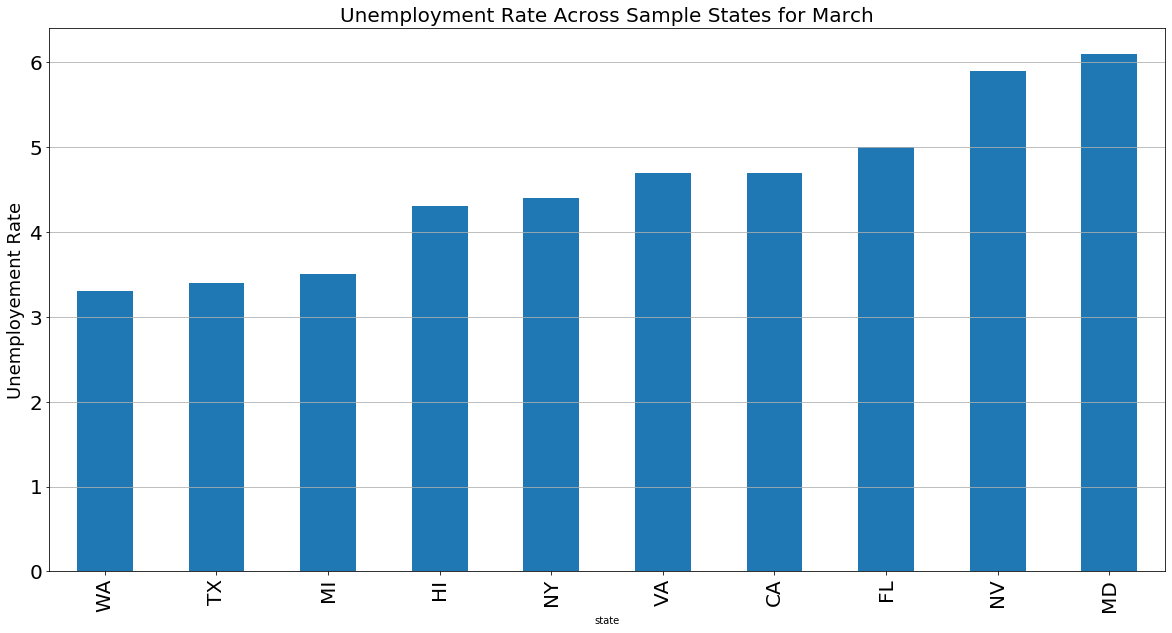

In [22]:
states = ["NY", "VA", "MD", "FL", "MI", "NV", "TX", "WA", "CA", "HI"]
msx_finalmonth = msx_cleaned[msx_cleaned['month']==3].sort_values("value")
msx_finalmonth[msx_finalmonth["state"].isin(states)].plot.bar(x='state', y='value', fontsize=20, legend=False, figsize=(20,10)).grid(axis='y')
plt.ylabel("Unemployment by States in March (2020)", fontsize=18)
plt.ylabel("Unemployement Rate", fontsize=18)
plt.title("Unemployment Rate Across Sample States for March", fontsize=20)
#fig.savefig('graph.png')

## <font color=blue> Todd's chat

In [23]:
covid_dataframe = pd.read_csv('spread_hist_by_state.csv')

covid_data = covid_dataframe[['date', 'state', 'positive', 'negative','recovered', 'dataQualityGrade', 'lastUpdateEt']].loc[covid_dataframe['dataQualityGrade'] != 'F']

state_geo_df = pd.read_csv('state_latlong.csv')
covid_df = pd.merge(covid_data, state_geo_df, how='left', left_on="state", right_on='state')

plot_df = covid_df[['latitude','longitude','date','positive', 'negative', 'state', 'recovered']].sort_values(by='date', axis=0, ascending=True).fillna(0)
# print(plot_df.loc[plot_df['latitude'] == 0]['state'].unique())
plot_df

,latitude,longitude,date,positive,negative,state,recovered
3913,47.751074,-120.740139,20200122,1.0,0.0,WA,0.0
3912,47.751074,-120.740139,20200123,1.0,0.0,WA,0.0
3911,47.751074,-120.740139,20200124,1.0,0.0,WA,0.0
3910,47.751074,-120.740139,20200125,1.0,0.0,WA,0.0
3909,47.751074,-120.740139,20200126,1.0,0.0,WA,0.0
...,...,...,...,...,...,...,...
32,41.492537,-99.901813,20200513,8692.0,41033.0,NE,0.0
31,47.551493,-101.002012,20200513,1647.0,47298.0,ND,969.0
30,35.759573,-79.019300,20200513,15816.0,194641.0,NC,9115.0
43,18.198719,-66.352675,20200513,2329.0,0.0,PR,0.0


In [24]:
main_map = folium.Map(
    [plot_df['latitude'].mean(),plot_df['longitude'].mean()],
    tiles='stamentoner',
    zoom_start=4,
    max_opacity=0.9,
    blur=4
)

#heat_data_pos_grp = []
#heat_data_neg_grp = []
#heat_data_rec_grp = []
date_indx = []

layer_types = [{'title' : 'Covid : Tested Positive',
                'status' : 'positive',
                'show' : True,
                'plot_data' : [],
                'gr_val' : [.2,.9,.3],
                'gr_clr' : ['red','orange','red'],
                'rad' : 1.5
               },
               {'title' : 'Covid : Tested Negative',
                'status' : 'negative',
                'show' : False,
                'plot_data' : [],
                'gr_val' : [.9,.3,.3],
                'gr_clr' : ['green','yellow','lime'],
                'rad' : 1
               },
               {'title' : 'Covid : Recovered',
                'status' : 'recovered',
                'show' : False,
                'plot_data' : [],
                'gr_val' : [.5,.5,.5],
                'gr_clr' : ['blue','blue','blue'],
                'rad' : 1
               }]

for date_stp in plot_df['date'].unique():
    heat_df = plot_df.loc[plot_df['date'] == date_stp].dropna(axis=0, subset=['latitude', 'longitude', 'positive', 'negative', 'recovered', 'date'])
    dt = str(date_stp)
    y = int(dt[:4])
    m = int(dt[4:6])
    d = int(dt[6:])
    date_indx.append(datetime(y,m,d).strftime("%Y-%m-%d"))    
    heat_data_pos_date = []
    heat_data_neg_date = []
    heat_data_rec_date = []
    for row in heat_df.itertuples():
        pos_magna = int(row.positive)
        neg_magna = int(row.negative)
        rec_magna = int(row.recovered)
        #if pos_magna > 1000: pos_magna = 1000
        #print(f'pos_magna [{pos_magna}]')
        if pos_magna > 0:
            #heat_data_pos_date.append([row.latitude * random.uniform(1.0004,1.001), row.longitude * random.uniform(1.0004,1.001), row.positive])
            #heat_point = [row.latitude, row.longitude, 1]
            heat_point = [row.latitude * random.uniform(1.0001,1.0005), row.longitude * random.uniform(1.0001,1.0005), 1]
            heat_data_pos_date.append(heat_point)
            #heat_point = [row.latitude, row.longitude, 1]
            #[heat_data_pos_date.append(heat_point) for i in range(pos_magna)]
        if neg_magna > 0:
            #heat_data_neg_date.append([row.latitude * random.uniform(1.0004,1.001), row.longitude * random.uniform(1.0004,1.001), row.negative])
            #heat_point = [row.latitude * random.uniform(.995,1.005), row.longitude * random.uniform(.995,1.005), 1]
            heat_point = [row.latitude, row.longitude, 1]
            heat_data_neg_date.append(heat_point) 
            #[heat_data_neg_date.append(heat_point) for i in range(neg_magna)]
        if rec_magna > 0:
            #heat_data_rec_date.append([row.latitude * random.uniform(1.0004,1.001), row.longitude * random.uniform(1.0004,1.001), row.recovered])
            #heat_point = [row.latitude * random.uniform(.995,1.005), row.longitude * random.uniform(.995,1.005), 1]
            heat_point = [row.latitude, row.longitude, 1]
            heat_data_rec_date.append(heat_point)
            #[heat_data_rec_date.append(heat_point) for i in range(rec_magna)]
            
    #print(f'heat_data_pos_date [{heat_data_pos_date}]')
    layer_types[0]['plot_data'].append(heat_data_pos_date)
    layer_types[1]['plot_data'].append(heat_data_neg_date)
    layer_types[2]['plot_data'].append(heat_data_rec_date)

print(f'layer_types[0]["plot_data"] [{len(layer_types[0]["plot_data"])}] date_indx [{len(date_indx)}]')
#print(f'layer_types[0][3] {"--"* 40}\n{layer_types[0][3]}')
#print(f'layer_types[0]["plot_data"] [{layer_types[0]["plot_data"]}]')

for layer_type in layer_types:

    #feature_sub_grp = folium.plugins.FeatureGroupSubGroup(map_Feature_Group,layer_type[0]+'_grp', show=layer_type[2])
    map_Feature_Group = folium.FeatureGroup(name=layer_type['title'], show=layer_type['show'])
    main_map.add_child(map_Feature_Group)
    #main_map.add_child(feature_sub_grp)

    Heat_mapw_time = plugins.HeatMapWithTime(
        data = layer_type['plot_data'],
        index = date_indx,
        auto_play = True,
        use_local_extrema = True,
        radius = layer_type['rad'],
        min_opacity = 0.5,
        scale_radius = True,
        name = layer_type['title'],
        gradient={layer_type['gr_val'][0]: layer_type['gr_clr'][0],
                  layer_type['gr_val'][1]: layer_type['gr_clr'][1],
                  layer_type['gr_val'][2]: layer_type['gr_clr'][2]}
    )
     #control=layer_type[2]

    main_map.add_child(Heat_mapw_time)

    
#marker_cluster = MarkerCluster().add_to(map_Feature_Group)
#folium.TileLayer(layer_type[0]).add_to(map)    
# add the layer control
folium.LayerControl().add_to(main_map)


main_map

layer_types[0]["plot_data"] [113] date_indx [113]
